In [1]:
from graph_tool.all import *
import graph_tool.all as gt
import numpy as np
import scipy as sp
from scipy.integrate import simpson
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PyGnuplot import gp
import subprocess

In [2]:
Node = 10000

m = 2

times = 100

M_list  = [5, 10, 20, 50, 100, 200]

beta_list = [1,1/2,0,-1,-3,-5,-100]

net_list = ["SF", "Cutoff", "RA", "IPA_beta1", "IPA_beta3", "IPA_beta5", "IPA_beta100"]

In [3]:
from decimal import Decimal

w_list = [0.00, 0.50, 0.70, 0.90, 0.95, 0.98]

w_list = [Decimal(str(item)).quantize(Decimal('0.00')) for item in w_list]

In [4]:
def inter_intra(g):
    # intra, interlinkのリストを初期化
    intra_link = []
    inter_link = []
        
    # intra, interlinkを識別
    for edge in g.edges():
        source_vertex = edge.source()
        target_vertex = edge.target()
    
        if g.vp.module_number[source_vertex] == g.vp.module_number[target_vertex]:
            intra_link.append(edge)
        else:
            inter_link.append(edge)
            
    return intra_link

def module_based_attack(graph, intra_link):
    
    #### 3. コミュニティ間の接続に参加しているノード（またはエッジ）のリストを作成する。 ####
    
    # 空の集合を作成（重複の排除）
    intercommunity_nodes = set()
    # Gの全てのedgeに対してループを回す
    for edge in graph.edges():
        # 現在のedgeの始点ノードを取得
        source_vertex = edge.source()
        # 現在のedgeの終点ノードを取得
        target_vertex = edge.target()
        # 始点ノードと終点ノードが異なるモジュールに所属していれば、
        if graph.vp.module_number[source_vertex] != graph.vp.module_number[target_vertex]:
            # intercommunity_nodesにノードを追加
            intercommunity_nodes.add(source_vertex)
            intercommunity_nodes.add(target_vertex)

    #### 4. (ノードまたはエッジの)間の中心性の降順に従ってリストをソートする。 ####
    # ノードの媒介中心性のリストを返す
    node_betweenness = gt.betweenness(graph)[0]
    # intercommunity_nodesのリストを媒介中心性の高い順にソートする
    sorted_nodes = sorted(intercommunity_nodes, key=lambda v: node_betweenness[v], reverse=True)

    #### 5. リストの先頭から1つずつノード（またはエッジ）を削除する。 ####
    #### 6. 2つのコミュニティ間のリンクからノードが削除されると、他のコミュニティ間の接続にもう一方のノードが参加していない限り、 ####
    ####    そのノードはリストからスキップされる。 ####
    #### 7. 攻撃は常にネットワークの最大連結成分に限定される。####
    
    # 削除されるノードの保存用リストを初期化
    removed_nodes = []
    # ソートされたノードがなくなるまでループ
    while sorted_nodes:
        # リストからノードを取り出す
        node = sorted_nodes.pop(0)
        # ノードがすでにremoved_nodesにないかを確認。リストになければ、、
        if node not in removed_nodes:
            # removed_nodesにノードを追加
            removed_nodes.append(node)

            # そのノードに隣接する全てのノードを取得し、その数だけループを繰り返す
            for neighbor in node.all_neighbors():
                
                # 隣接ノードとそのノードのモジュール番号が違ければ、、、
                if graph.vp.module_number[neighbor] != graph.vp.module_number[node]:
                    # その隣接ノードがまだsorted_nodesに存在すれば、、、
                    if neighbor in sorted_nodes:
                        # sorted_nodesから隣接ノードを削除する
                        sorted_nodes.remove(neighbor)

            # Gの最大連結成分に含まれるノードに対してTrueを、それ以外のノードに対してFalseを持つブールマスクを返す
            lcc_vertex_mask = gt.label_largest_component(graph)
            # Trueとなるノードのみをsorted_nodesに格納
            sorted_nodes = [v for v in sorted_nodes if lcc_vertex_mask[v]]

    # 削除されたノードの数がグラフ graphの全ノード数より少ない場合
    if len(removed_nodes) < graph.num_vertices():
        # まだ削除リストに含まれていないノードのセットを計算
        nodes_not_removed = set(graph.iter_vertices()) - set(removed_nodes)
        # どれだけのノードが削除リストに追加されるべきかを計算
        padding_required = graph.num_vertices() - len(removed_nodes)
    
        # 削除リストに含まれていないノードの数だけループ
        for node in nodes_not_removed:
            # もし、padding_requiredが0になれば、処理を終了
            if padding_required <= 0:
                break
            # 削除リストノードを追加
            removed_nodes.append(node)
            # 必要なノード数を１減少
            padding_required -= 1

    #print(len(removed_nodes))
    # リストを逆順に。
    removed_nodes.reverse()
    return removed_nodes

In [5]:
for M in tqdm(M_list):
    all_R_list = []
    for net in tqdm(net_list):
        R_net_list = []
        for w in tqdm(w_list):
            MB = []
            for i in range(times):
                g = load_graph(f"~/o_t_hayashilab/Network_data/graph-tool/modular_structure/{net}/w={w}/m0={M}/{i}.gt.gz")
                
                intra_link = inter_intra(g)
                module_base = module_based_attack(g, intra_link)
                sizes, comp = gt.vertex_percolation(g, module_base)
                module_attack = [frc for frc in sizes]
                perc = np.array(module_attack)
                perc = perc / Node
                
                MB.append(perc)
                
            MB_ave = np.mean(MB, axis=0)
            R = simpson(MB_ave, dx=1/Node)
            R_net_list.append(R)
            
        all_R_list.append(R_net_list)
        
    # 保存先のディレクトリが存在しない場合は作成
    save_dir = f'~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/'
    os.makedirs(os.path.expanduser(save_dir), exist_ok=True)
    np.save(os.path.join(os.path.expanduser(save_dir), 'MB_R_list.npy'), np.array(all_R_list))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [1:40:28<8:22:23, 6028.73s/it]

 33%|███▎      | 2/6 [2:44:14<5:15:32, 4733.12s/it]

 50%|█████     | 3/6 [3:25:06<3:04:33, 3691.13s/it]

 67%|██████▋   | 4/6 [3:41:07<1:27:07, 2613.66s/it]

 83%|████████▎ | 5/6 [3:51:42<31:40, 1900.05s/it]  

100%|██████████| 6/6 [3:59:36<00:00, 2396.12s/it]

 14%|█▍        | 1/7 [3:59:36<23:57:40, 14376.72s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [1:35:28<7:57:20, 5728.19s/it]

 33%|███▎      | 2/6 [2:41:27<5:12:31, 4687.87s/it]

 50%|█████     | 3/6 [3:25:17<3:07:24, 3748.28s/it]

 67%|██████▋   | 4/6 [3:42:56<1:29:32, 2686.35s/it]

 83%|████████▎ | 5/6 [3:54:29<32:47, 1967.43s/it]  

100%|██████████| 6/6 [4:03:07<00:00, 2431.27s/it]

 29%|██▊       | 2/7 [8:02:44<20:08:23, 14500.77s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [1:33:16<7:46:22, 5596.42s/it]

 33%|███▎      | 2/6 [2:42:37<5:16:48, 4752.17s/i

In [4]:
from scipy.stats import pearsonr
# 単相関係数を計算して表示する関数
def calculate_and_display_correlation(x_values, y_values, label):
    correlation, _ = pearsonr(x_values, y_values)
    print(f"{label} の単相関係数: {correlation:.4f}")
    return correlation

v=1 の単相関係数: 0.8709
v=-3 の単相関係数: 0.9840
v=1/2 の単相関係数: 0.9528
v=-5 の単相関係数: 0.9666
v=0 の単相関係数: 0.9772
v=-100 の単相関係数: 0.9599
v=-1 の単相関係数: 0.9948


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


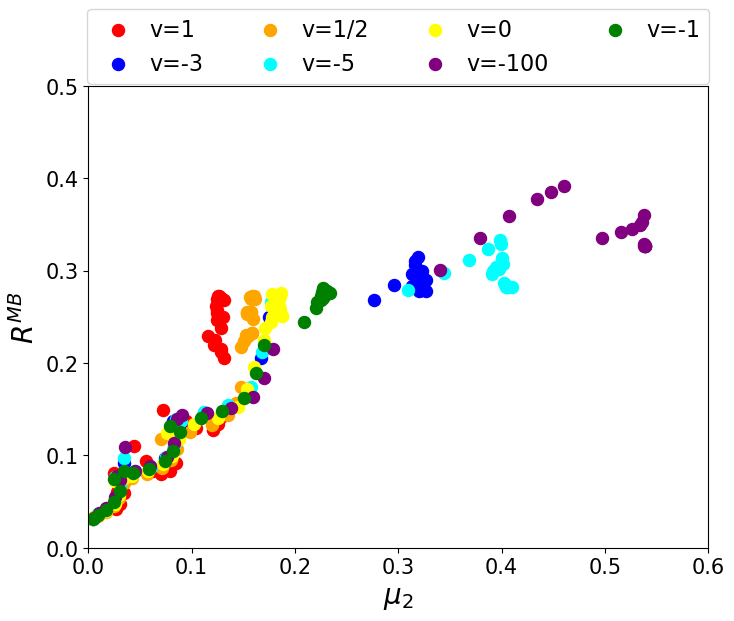

In [5]:
# 散布図を作成する関数（点線のプロットを除去）
def plot_correlation(x_values, y_values, label, color, marker='o', size=100):  # size引数を追加
    plt.scatter(x_values, y_values, label=label, color=color, marker=marker, s=size)

v1_R = []
v1_mu = []
v2_R = []
v2_mu = []
v3_R = []
v3_mu = []
v4_R = []
v4_mu = []
v5_R = []
v5_mu = []
v6_R = []
v6_mu = []
v7_R = []
v7_mu = []
    
for M in M_list:
    save_path = f"~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/MB_R_list.npy"
    ID_R_file = np.load(os.path.expanduser(save_path), allow_pickle=True)
    v1_R.append(ID_R_file[0])
    v2_R.append(ID_R_file[1])
    v3_R.append(ID_R_file[2])
    v4_R.append(ID_R_file[3])
    v5_R.append(ID_R_file[4])
    v6_R.append(ID_R_file[5])
    v7_R.append(ID_R_file[6])
    save_path = f"~/o_t_hayashilab/modular_network_info/N={Node}/m0={M}/second_eigenvalue_list.npy"
    μ_file = np.load(os.path.expanduser(save_path), allow_pickle=True)
    v1_mu.append(μ_file[0])
    v2_mu.append(μ_file[1])
    v3_mu.append(μ_file[2])
    v4_mu.append(μ_file[3])
    v5_mu.append(μ_file[4])
    v6_mu.append(μ_file[5])
    v7_mu.append(μ_file[6])

v1_R = np.array(v1_R).flatten()
v1_mu = np.array(v1_mu).flatten()
v2_R = np.array(v2_R).flatten()
v2_mu = np.array(v2_mu).flatten()
v3_R = np.array(v3_R).flatten()
v3_mu = np.array(v3_mu).flatten()
v4_R = np.array(v4_R).flatten()
v4_mu = np.array(v4_mu).flatten()
v5_R = np.array(v5_R).flatten()
v5_mu = np.array(v5_mu).flatten()
v6_R = np.array(v6_R).flatten()
v6_mu = np.array(v6_mu).flatten()
v7_R = np.array(v7_R).flatten()
v7_mu = np.array(v7_mu).flatten()
    
# 散布図を作成
plt.figure(figsize=(8, 6))

plot_correlation(v1_mu, v1_R, label='v=1', color='red', size=75)
correlation_v1 = calculate_and_display_correlation(v1_mu, v1_R, label='v=1')

plot_correlation(v5_mu, v5_R, label='v=-3', color='blue', size=75)
correlation_v2 = calculate_and_display_correlation(v5_mu, v5_R, label='v=-3')

plot_correlation(v2_mu, v2_R, label='v=1/2', color='orange', size=75)
correlation_v3 = calculate_and_display_correlation(v2_mu, v2_R, label='v=1/2')

plot_correlation(v6_mu, v6_R, label='v=-5', color='cyan', size=75)
correlation_v4 = calculate_and_display_correlation(v6_mu, v6_R, label='v=-5')

plot_correlation(v3_mu, v3_R, label='v=0', color='yellow', size=75)
correlation_v5 = calculate_and_display_correlation(v3_mu, v3_R, label='v=0')

plot_correlation(v7_mu, v7_R, label='v=-100', color='purple', size=75)
correlation_v6 = calculate_and_display_correlation(v7_mu, v7_R, label='v=-100')

plot_correlation(v4_mu, v4_R, label='v=-1', color='green', size=75)
correlation_v7 = calculate_and_display_correlation(v4_mu, v4_R, label='v=-1')
    
# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{MB}$", fontsize=20)

# x軸の範囲を設定（0から最大値+0.05）
plt.xlim(0, 0.6)
# x軸の目盛りを調整（ここでは0.1刻みに設定し、フォントサイズを15に）
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)

# y軸の範囲を設定（0から最大値+0.05）
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定（上に2×2で配置）
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# 保存先のディレクトリを指定
save_dir = os.path.expanduser('~/o_t_hayashilab/modular_network_info/μ_R_correlation/')
os.makedirs(save_dir, exist_ok=True)  # ディレクトリが存在しない場合は作成
# EPS形式で図を保存（フルパスを指定）
save_path = os.path.join(save_dir, f"R^MB_mu2.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

In [6]:
mu_all = np.concatenate([v1_mu, v2_mu, v3_mu, v4_mu, v5_mu, v6_mu, v7_mu])
R_all = np.concatenate([v1_R, v2_R, v3_R, v4_R, v5_R, v6_R, v7_R])

# 全データの相関係数を計算
overall_correlation = np.corrcoef(mu_all, R_all)[0, 1]  # 相関係数マトリックスから[0,1]成分を取得

# 全体の相関係数を表示
print(f"全データの相関係数: {overall_correlation:.3f}")

全データの相関係数: 0.872


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


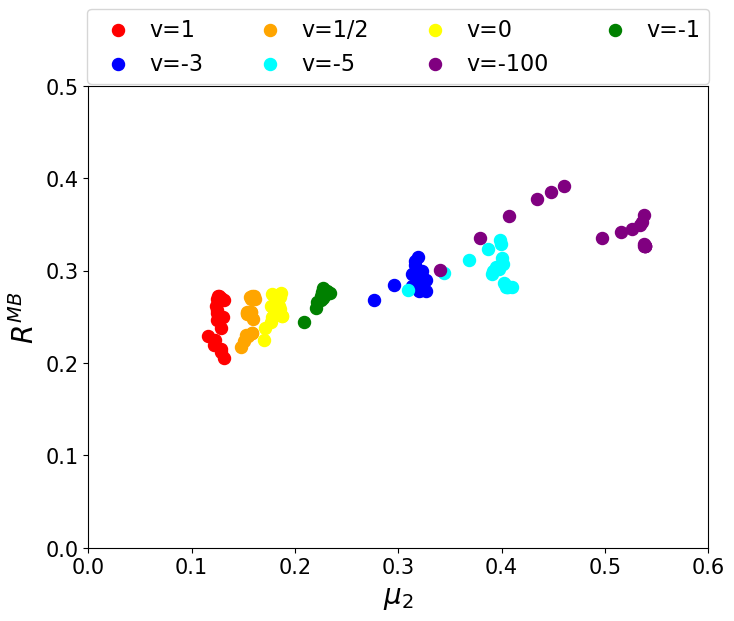

Overall correlation: 0.8524033924966236


In [15]:
# 抽出するインデックスリスト
indices = [0, 1, 2, 6, 7, 8, 12, 13, 14, 18, 19, 20, 24, 25, 26, 30, 31, 32]

# 抽出して新しいリストに格納
v1_R_selected = v1_R[indices]
v1_mu_selected = v1_mu[indices]
v2_R_selected = v2_R[indices]
v2_mu_selected = v2_mu[indices]
v3_R_selected = v3_R[indices]
v3_mu_selected = v3_mu[indices]
v4_R_selected = v4_R[indices]
v4_mu_selected = v4_mu[indices]
v5_R_selected = v5_R[indices]
v5_mu_selected = v5_mu[indices]
v6_R_selected = v6_R[indices]
v6_mu_selected = v6_mu[indices]
v7_R_selected = v7_R[indices]
v7_mu_selected = v7_mu[indices]

# 新しい散布図を作成
plt.figure(figsize=(8, 6))

# リスト1のプロット
plot_correlation(v1_mu_selected, v1_R_selected, label='v=1', color='red', size=75)
plot_correlation(v5_mu_selected, v5_R_selected, label='v=-3', color='blue', size=75)
plot_correlation(v2_mu_selected, v2_R_selected, label='v=1/2', color='orange', size=75)
plot_correlation(v6_mu_selected, v6_R_selected, label='v=-5', color='cyan', size=75)
plot_correlation(v3_mu_selected, v3_R_selected, label='v=0', color='yellow', size=75)
plot_correlation(v7_mu_selected, v7_R_selected, label='v=-100', color='purple', size=75)
plot_correlation(v4_mu_selected, v4_R_selected, label='v=-1', color='green', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{MB}$", fontsize=20)

# x軸とy軸の範囲設定
plt.xlim(0, 0.6)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# EPS形式で保存
save_path = os.path.join(save_dir, f"R^MB_mu2_selected.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

# すべてのデータを結合
all_mu = np.concatenate([v1_mu_selected, v2_mu_selected, v3_mu_selected, v4_mu_selected, v5_mu_selected, v6_mu_selected, v7_mu_selected])
all_R = np.concatenate([v1_R_selected, v2_R_selected, v3_R_selected, v4_R_selected, v5_R_selected, v6_R_selected, v7_R_selected])

# 全体の相関係数を計算
overall_corr = np.corrcoef(all_mu, all_R)[0, 1]

# 結果を表示
print(f"Overall correlation: {overall_corr}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


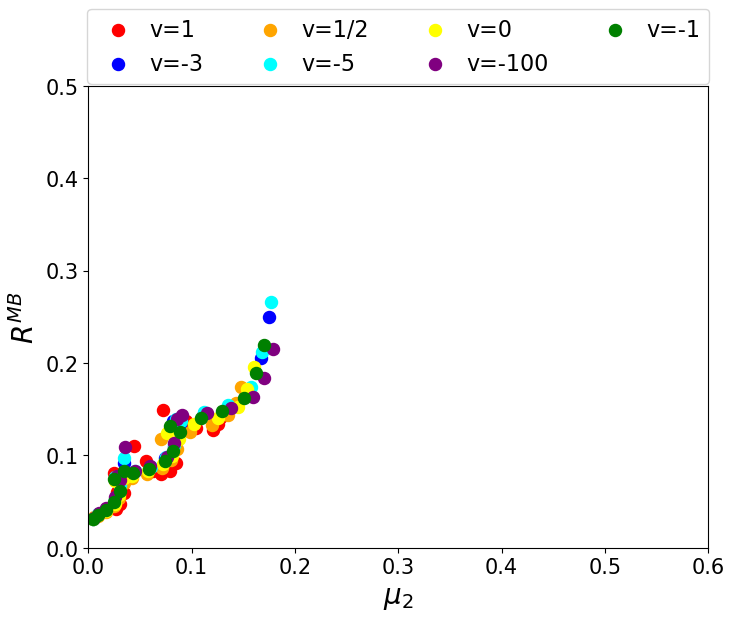

Overall correlation: 0.9514154620136874


In [16]:
# 選択されなかったインデックスを取得
all_indices = np.arange(len(v1_R))  # 元の配列のインデックス全体
unselected_indices = np.delete(all_indices, indices)  # 選択されなかったインデックスを取得

# 抽出して新しいリストに格納（未選択の要素）
v1_R_unselected = v1_R[unselected_indices]
v1_mu_unselected = v1_mu[unselected_indices]
v2_R_unselected = v2_R[unselected_indices]
v2_mu_unselected = v2_mu[unselected_indices]
v3_R_unselected = v3_R[unselected_indices]
v3_mu_unselected = v3_mu[unselected_indices]
v4_R_unselected = v4_R[unselected_indices]
v4_mu_unselected = v4_mu[unselected_indices]
v5_R_unselected = v5_R[unselected_indices]
v5_mu_unselected = v5_mu[unselected_indices]
v6_R_unselected = v6_R[unselected_indices]
v6_mu_unselected = v6_mu[unselected_indices]
v7_R_unselected = v7_R[unselected_indices]
v7_mu_unselected = v7_mu[unselected_indices]

# 新しい散布図を作成（未選択要素のプロット）
plt.figure(figsize=(8, 6))

# リスト1のプロット
plot_correlation(v1_mu_unselected, v1_R_unselected, label='v=1', color='red', size=75)
plot_correlation(v5_mu_unselected, v5_R_unselected, label='v=-3', color='blue', size=75)
plot_correlation(v2_mu_unselected, v2_R_unselected, label='v=1/2', color='orange', size=75)
plot_correlation(v6_mu_unselected, v6_R_unselected, label='v=-5', color='cyan', size=75)
plot_correlation(v3_mu_unselected, v3_R_unselected, label='v=0', color='yellow', size=75)
plot_correlation(v7_mu_unselected, v7_R_unselected, label='v=-100', color='purple', size=75)
plot_correlation(v4_mu_unselected, v4_R_unselected, label='v=-1', color='green', size=75)

# 軸ラベルの設定
plt.xlabel(r"$μ_{2}$", fontsize=20)
plt.ylabel(r"$R^{MB}$", fontsize=20)

# x軸とy軸の範囲設定
plt.xlim(0, 0.6)
plt.xticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=15)
plt.ylim(0, 0.5)
plt.yticks(ticks=[0, 0.1, 0.2, 0.3, 0.4, 0.5], fontsize=15)

# 凡例の設定
plt.legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.19), ncol=4, handletextpad=0.4)

# EPS形式で保存
save_path = os.path.join(save_dir, f"R^MB_mu2_unselected.eps")
plt.savefig(save_path, format='eps', bbox_inches='tight')

# プロットの表示
plt.show()

# すべてのデータを結合
all_mu = np.concatenate([v1_mu_unselected, v2_mu_unselected, v3_mu_unselected, v4_mu_unselected, v5_mu_unselected, v6_mu_unselected, v7_mu_unselected])
all_R = np.concatenate([v1_R_unselected, v2_R_unselected, v3_R_unselected, v4_R_unselected, v5_R_unselected, v6_R_unselected, v7_R_unselected])

# 全体の相関係数を計算
overall_corr = np.corrcoef(all_mu, all_R)[0, 1]

# 結果を表示
print(f"Overall correlation: {overall_corr}")